**backtrader包主要组成部分：**
1. 数据加载（Data Feed）：将交易策略的数据加载到回测框架中。
2. 交易策略（Strategy）：设计交易决策，得出买入/卖出信号。
3. 回测框架设置（Cerebro）：初始资金；佣金；数据馈送；交易策略；交易头寸大小。
4. 运行回测：运行Cerebro回测并打印出所有自己执行的交易。
5. 评估性能（Analyzers）：以图形和风险收益等指标对交易策略的回测结果进行评价。

In [34]:
class my_strategy1(bt.Strategy):
    #全局设定交易策略的参数
    params=(
        ('maperiod',20),
           )

    def __init__(self):
        #指定价格序列
        self.dataclose=self.datas[0].close
        # 初始化交易指令、买卖价格和手续费
        self.order = None
        self.buyprice = None
        self.buycomm = None

        #添加移动均线指标，内置了talib模块
        self.sma = bt.indicators.SimpleMovingAverage(
                      self.datas[0], period=self.params.maperiod)
    def next(self):
        if self.order: # 检查是否有指令等待执行, 
            return
        # 检查是否持仓   
        if not self.position: # 没有持仓
            #执行买入条件判断：收盘价格上涨突破20日均线
            if self.dataclose[0] > self.sma[0]:
                #执行买入
                self.order = self.buy(size=500)         
        else:
            #执行卖出条件判断：收盘价格跌破20日均线
            if self.dataclose[0] < self.sma[0]:
                #执行卖出
                self.order = self.sell(size=500)

In [35]:
mpl.rcParams['axes.unicode_minus']=False

#先引入后面可能用到的包（package）
import pandas as pd  
from datetime import datetime
import backtrader as bt
import matplotlib.pyplot as plt
%matplotlib inline   

#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']

## 数据加载（Data Feeds）

In [36]:
#使用tushare旧版接口获取数据
import tushare as ts 
def get_data(code,start='2010-01-01',end='2020-03-31'):
    df=ts.get_k_data(code,autype='qfq',start=start,end=end)
    df.index=pd.to_datetime(df.date)
    df['openinterest']=0
    df=df[['open','high','low','close','volume','openinterest']]
    return df
dataframe=get_data('600000')

#回测期间
start=datetime(2010, 3, 31)
end=datetime(2020, 3, 31)
# 加载数据
data = bt.feeds.PandasData(dataname=dataframe,fromdate=start,todate=end)

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
timed out


## 回测设置（Cerebro）

In [42]:
# 初始化cerebro回测系统设置                           
cerebro = bt.Cerebro()  
#将数据传入回测系统
cerebro.adddata(data) 
# 将交易策略加载到回测系统中
cerebro.addstrategy(my_strategy1) 
# 设置初始资本为10,000
startcash = 10000
cerebro.broker.setcash(startcash) 
# 设置交易手续费为 0.2%
cerebro.broker.setcommission(commission=0.002) 

## 执行回测

In [44]:
d1=start.strftime('%Y%m%d')
d2=end.strftime('%Y%m%d')
print(f'初始资金: {startcash}\n回测期间：{d1}:{d2}')
#运行回测系统
cerebro.run()
#获取回测结束后的总资金
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash
#打印结果
print(f'总资金: {round(portvalue,2)}')
print(f'净收益: {round(pnl,2)}')

初始资金: 10000
回测期间：20100331:20200331
总资金: 12000.36
净收益: 2000.36


## 可视化

<IPython.core.display.Javascript object>


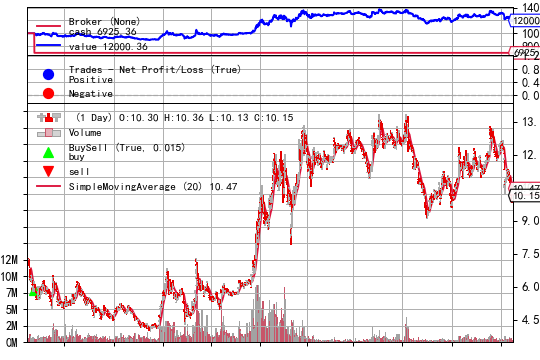

[[<Figure size 432x288 with 4 Axes>]]

In [45]:
cerebro.plot(style='candlestick')